In [16]:
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import RLAgent

# Import other uttilities
from reinforcetrader.utils.portfolio_manager import PortfolioBackTester

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

# Data Pre-processing and Feature Building

In [2]:
# Get DJI raw data using Yahoo Finance API
data_loader = RawDataLoader(start_date='1999-08-01', end_date='2025-09-08', index='DJI', verbose=True)

# Download or load the data from cache
ticker_data, benchmark_data = data_loader.get_hist_prices()

# Inspect the raw DJI tickers and the benchmark data
print('Tickers Data:')
display_df(ticker_data)

print('Benchmark Data:')
display_df(benchmark_data)

Loading cached data from data/raw/DJI_tickers_data_1999-08-01_2025-09-08.csv


[*********************100%***********************]  1 of 1 completed

Dropped 0 tickers. 1 tickers left.
Tickers dropped: 
Tickers Data:


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT
Price,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-08-02,0.418406,27.008623,2.350000,26.759935,29.387835,15.095907,20.226336,17.283491,20.469774,43.679104,24.310881,34.258572,60.700535,23.358135,24.693949,14.641418,22.785522,18.153017,25.379469,25.952599,4.675046,0.038803,22.806919,6.088423,16.810501,6.075971,17.081631,9.014959,0.435292,27.437331,2.553125,27.930121,29.828853,15.192573,20.942131,17.532089,20.987401,44.896034,25.017311,34.557918,62.562517,23.612201,24.772842,14.915659,22.818835,18.356555,25.873875,26.602848,4.884899,0.038922,23.091610,6.158245,17.071635,6.217130,17.213028,9.254295,0.416529,26.279819,2.348438,26.708499,28.866631,15.047575,20.042274,17.224301,20.469774,43.374871,24.164723,34.158789,60.483305,23.246982,24.240305,14.626183,22.085967,17.733221,25.285297,25.818724,4.640071,0.038206,22.727838,6.032566,16.353517,5.990048,16.818836,8.935181,0.417467,26.279819,2.459375,27.158568,29.107187,15.112018,20.185433,17.295329,20.752116,44.678725,24.603196,34.358356,61.569460,23.358135,24.279753,14.763303,22.119279,17.898595,25.332381,26.220348,4.838265,0.038444,22.727838,6.032566,16.451442,5.990048,16.884535,9.001663,362443200,14186400,339356000,8751857,2641100,2118000,28405600,1705000,3526812,566400,4064100,1146355,4775095,3559800,6278850,5161000,2372700,2258287,3458295,48050600,14422400,313344000,4158800,581400,377100,3470400,3194070,16741800
1999-08-03,0.414653,26.279812,2.371875,26.065540,30.189678,14.918688,20.001377,17.614952,20.187431,42.288319,23.628815,33.826187,59.273018,23.929771,24.871460,14.824247,22.585657,18.343847,25.238213,25.933479,4.593437,0.037848,23.708441,6.046532,16.777855,5.627944,16.818836,8.921886,0.431070,27.158664,2.425000,27.055698,30.189678,15.192573,20.471757,17.626790,20.658002,43.679096,24.457040,34.491402,61.135000,24.136199,24.910907,14.900425,22.818842,18.394732,25.661988,26.335104,4.814948,0.038803,23.850786,6.102390,16.973705,5.891849,17.180178,9.121332,0.402457,25.786797,2.240625,25.924090,29.508105,14.805912,19.715059,17.259812,19.905089,42.244857,23.580094,33.593362,58.683391,23.643948,24.615053,14.656656,22.285848,18.178472,25.096955,25.818729,4.587608,0.037489,22.854368,5.990675,16.614646,5.609532,16.769563,8.788922,0.425910,27.072922,2.425000,26.901387,29.508105,15.095908,20.451306,17.567600,20.469773,43.679096,24.262164,34.258577,60.948800,23.850376,24.693948,14.656656,22.652281,18.292963,25.544272,26.277729,4.768314,0.038803,22.870184,6.060497,16.745213,5.891849,17.048781,9.054850,368379200,11616400,582780000,8694619,2854000,2275600,32937000,2072200,7458388,837700,585

Benchmark Data:


Price,Close,High,Low,Open,Volume
Date,,,,,
1999-08-02,10645.959961,10791.599609,10615.250000,10654.830078,68670000
1999-08-03,10677.309570,10727.969727,10613.990234,10645.959961,76710000
1999-08-04,10674.769531,10829.910156,10670.030273,10675.660156,88660000
1999-08-05,10793.820312,10798.250000,10566.179688,10675.410156,124250000
1999-08-06,10714.030273,10818.200195,10653.250000,10792.580078,84820000
1999-08-09,10707.700195,10761.839844,10683.320312,10714.030273,81310000
1999-08-10,10655.150391,10714.669922,10549.080078,10704.219727,98920000
1999-08-11,10787.799805,10795.719727,10646.910156,10650.589844,85160000
1999-08-12,10789.389648,10900.830078,10780.839844,10785.650391,71310000


In [3]:
# TODO: Read the reward params from config as they are used to compute reward function features
reward_params = {
    'Hb': [10, 15, 20, 25],
    'Hs': [3, 5, 10],
    'cost': 0.0005,
    "tb": 0.7700477308294275,
    "ts": 0.09043612300409239,
    "gamma": 1.0042817578361036,
    "alpha": 1.4927391153001819,
    "beta": 0.000980861419493323,
    "lambda": 1.0534657241256284,
    "upsilon": 0.19529168890555006,
    "mu": 0.09874476504473068}

horizons = list(dict.fromkeys(reward_params['Hs'] + reward_params['Hb']))

In [4]:
# Instantiate Feature Builder to Build relevant features for state space
feature_builder = FeatureBuilder(ticker_data=ticker_data, benchmark_data=benchmark_data, return_horizons=horizons)

# Build the features
feature_builder.build_features()

# Store the computed features and the feature index ranges (used later)
features_data = feature_builder.get_features()
feature_indices = feature_builder.get_feature_indices()

# Inspect the features
display_df(features_data, rows=20)

Building ticker features: 100%|█████████████████████████████████████| 28/28 [00:03<00:00,  8.30it/s]


File already exists, skipping save: data/processed/DJI_tickers_features_2000-03-06_2025-07-31.csv


# Episode Data Representation

In [5]:
state_loader = EpisodeStateLoader(features_data, feature_indices, 'configs/regimes_trans_incl_episodes.json')

In [6]:
state_loader.get_state_matrix('train', 1, 'AAPL', 2, 4)

array([[-1.29053265e-01,  7.09663749e-01,  1.61282986e-01,
        -7.57230639e-01,  1.00000000e+00,  4.03700769e-02,
        -2.36429229e-01, -2.92050868e-01,  6.30071282e-01,
        -1.32759643e+00,  9.70732495e-02,  1.13247655e-01,
        -6.99066103e-01],
       [-1.29053265e-01,  7.09663749e-01,  1.61282986e-01,
        -7.57230639e-01,  1.00000000e+00,  4.03700769e-02,
        -2.36429229e-01, -2.92050868e-01,  6.30071282e-01,
        -1.32759643e+00,  9.70732495e-02,  1.13247655e-01,
        -6.99066103e-01],
       [ 8.18185568e-01,  1.19834289e-01,  6.19801171e-02,
        -3.84119242e-01,  1.00000000e+00,  1.68797052e+00,
         4.09725785e-01, -5.48417214e-04,  1.06327617e+00,
        -1.00591528e+00,  2.72434443e-01,  1.29434720e-01,
         9.81722236e-01],
       [ 8.90233815e-01,  1.46419490e-02,  9.51242149e-02,
        -1.04718208e+00,  1.00000000e+00,  2.23730874e+00,
         1.17399979e+00,  4.39512551e-01,  1.19507837e+00,
        -2.23431140e-01,  3.73903751e

In [7]:
state_loader.get_state_OHLCV('train', 1, 'AAPL', 1)

array([9.1983503e-01, 1.0263125e+00, 9.1279948e-01, 1.0127097e+00,
       5.2432800e+08], dtype=float32)

In [8]:
state_loader.get_reward_computes('train', 1, 'AAPL', 1)

{'ExRet3': np.float32(0.008757087),
 'ExRet5': np.float32(0.027927157),
 'ExRet10': np.float32(-0.08150072),
 'ExRet15': np.float32(-0.15624133),
 'ExRet20': np.float32(-0.04869773),
 'ExRet25': np.float32(-0.109934375)}

# Deep Q-Network and RL Agent

In [9]:
# Init the RL agent and DQN Model
agent_config = {
    'num_motif_features': 5,
    'num_context_features': 8,
    'learning_rate': 1e-3,
    'memory_buffer_len': 100000,
    'state_matrix_window': 60,
    'epsilon_start': 1.0,
    'epsilon_min': 0.05,
    'epsilon_boost_factor': 0.5,
    'decay_updates': 50000,
    'discount_factor': 0.95
}

agent = RLAgent(agent_config=agent_config, reward_params=reward_params)

I0000 00:00:1757614527.887668    8289 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Train Agent

In [10]:
training_config = {
    'batch_size': 256,
    'val_group_size': 5,
    'replay_start_size': 5000,
    'train_interval': 1,
    'model_dir': 'model_checkpoints/',
    'plots_dir': 'plots/',
    'logs_dir': 'logs/'
}

Training episode 1: 100%|███████████████████████████████████████████| 28/28 [31:11<00:00, 66.85s/it]


Episode 1 validation summary:
Train loss: 59.7034, Val loss: -15.5764, Total val trades: 280, Hit rate: 0.55
Trade Duration: 2.13, Total PnL: 18.56, Profit Factor: 1.406
Force End Trade Count: 17, Force End PnL: 1.75


Training episode 2: 100%|███████████████████████████████████████████| 28/28 [36:39<00:00, 78.56s/it]


Episode 2 validation summary:
Train loss: 18.7409, Val loss: -6.5937, Total val trades: 35, Hit rate: 0.57
Trade Duration: 4.03, Total PnL: 4.24, Profit Factor: 1.842
Force End Trade Count: 8, Force End PnL: 2.31


Training episode 3: 100%|████████████████████████████████████████| 28/28 [1:47:29<00:00, 230.32s/it]


Episode 3 validation summary:
Train loss: 33.1266, Val loss: -39.8417, Total val trades: 365, Hit rate: 0.57
Trade Duration: 1.31, Total PnL: 9.30, Profit Factor: 1.174
Force End Trade Count: 1, Force End PnL: -0.03


Training episode 4: 100%|████████████████████████████████████████| 28/28 [1:17:30<00:00, 166.08s/it]


Episode 4 validation summary:
Train loss: 18.0950, Val loss: -25.0555, Total val trades: 305, Hit rate: 0.51
Trade Duration: 1.03, Total PnL: -1.33, Profit Factor: 0.971
Force End Trade Count: 3, Force End PnL: 0.21


Training episode 5: 100%|████████████████████████████████████████| 28/28 [2:13:45<00:00, 286.64s/it]


Episode 5 validation summary:
Train loss: 27.3587, Val loss: -35.9560, Total val trades: 1239, Hit rate: 0.54
Trade Duration: 1.01, Total PnL: 34.12, Profit Factor: 1.131
Force End Trade Count: 5, Force End PnL: 0.48


Training episode 6: 100%|████████████████████████████████████████| 28/28 [1:39:29<00:00, 213.18s/it]


Episode 6 validation summary:
Train loss: 18.0029, Val loss: -23.6591, Total val trades: 456, Hit rate: 0.52
Trade Duration: 1.01, Total PnL: 11.65, Profit Factor: 1.113
Force End Trade Count: 4, Force End PnL: 0.38


Training episode 7: 100%|████████████████████████████████████████| 28/28 [1:06:14<00:00, 141.94s/it]


Episode 7 validation summary:
Train loss: 11.7096, Val loss: -21.0000, Total val trades: 11, Hit rate: 0.73
Trade Duration: 27.09, Total PnL: 20.49, Profit Factor: 3.133
Force End Trade Count: 10, Force End PnL: 19.89


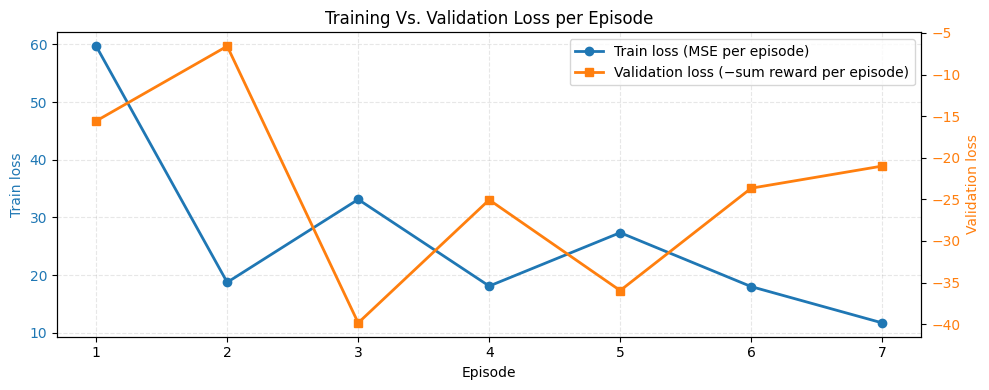

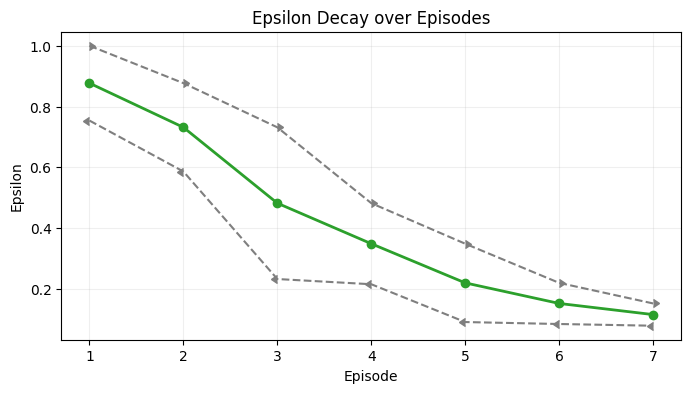

{1: {'train_loss': 59.703361868159845,
  'val_results': {'sum_reward': 15.576415188845317,
   'total_trades': 280,
   'trade_duration': 2.132142857142857,
   'hit_rate': 0.5535714285714286,
   'total_pnl': 18.56306877732277,
   'profit_factor': 1.4061132881906027,
   'force_end_trades': 17,
   'force_end_pnl': 1.75038543343544},
  'epsilon_start': 1.0,
  'epsilon_current': 0.8769040763696585,
  'epsilon_end': 0.7538081527393171},
 2: {'train_loss': 18.740949541330338,
  'val_results': {'sum_reward': 6.5937376928714615,
   'total_trades': 35,
   'trade_duration': 4.0285714285714285,
   'hit_rate': 0.5714285714285714,
   'total_pnl': 4.235190063714981,
   'profit_factor': 1.8423598602673712,
   'force_end_trades': 8,
   'force_end_pnl': 2.313098907470703},
  'epsilon_start': 0.8769040763696585,
  'epsilon_current': 0.7315843288987687,
  'epsilon_end': 0.586264581427879},
 3: {'train_loss': 33.12658902828116,
  'val_results': {'sum_reward': 39.84173913858769,
   'total_trades': 365,
   't

In [11]:
episode_list = list(range(1, 8))
agent.train(state_loader, episode_list, training_config)

# Test Agent Performance

In [13]:
test_config = {
    'plots_dir': 'plots/',
    'logs_dir': 'logs/',
    'outputs_dir': 'data/test/'
}
signals, prices = agent.test(state_loader, 1, test_config)

Testing episode 1: 100%|█████████████████████████████████████████| 28/28 [1:07:10<00:00, 143.95s/it]


Saved signals to data/test/signals_20250911_223500.pkl
Saved prices  to data/test/prices_20250911_223500.pkl


In [1]:
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import RLAgent

# Import other uttilities
from reinforcetrader.utils.portfolio_manager import PortfolioBackTester

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

signals_dir = 'data/test/signals_20250911_223500.pkl'
prices_dir = 'data/test/prices_20250911_223500.pkl'

signals, prices = pd.read_pickle(signals_dir), pd.read_pickle(prices_dir)

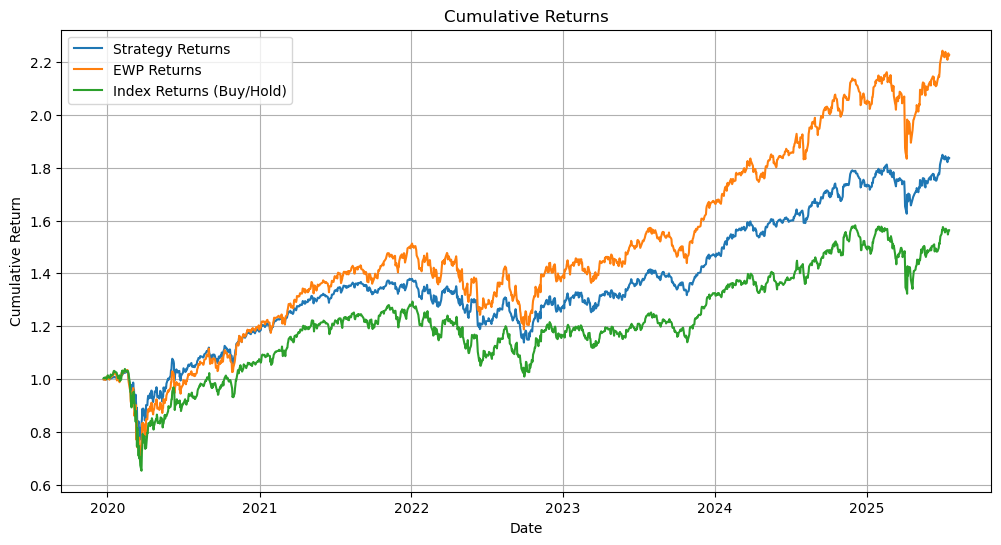

{'Total Strategy Returns': 0.8357810212088919,
 'Annualized Strategy Returns': -0.03179654724168879,
 'Max Strategy Drawdown': -0.2492739017789949,
 'EWP Total Return': 1.225780725479126,
 'EWP Annualized Return': 0.03735089302062988,
 'EWP Max Drawdown': -0.3293425440788269,
 'Index Total Return': 0.5633227139861097,
 'Index Annualized Return': -0.09821244220616965,
 'Index Max Drawdown': -0.370861713695943,
 'Sharpe Ratio (ann, rf=0)': 0.7915415803586033,
 'Sortino Ratio (ann, rf=0)': 0.9595668043176374,
 'Information Ratio (vs Index, ann)': 0.06928654199906883}


In [2]:
pbt = PortfolioBackTester(signals, prices)
pbt.run_backtest()